<a href="https://colab.research.google.com/github/tracyqian0720/Beginner-Guide-to-Detectron2/blob/main/CIFAR10%20and%20CIFAR100%20with%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment**: Designing and Tuning a Convolutional Neural Network (CNN)

**Assignment Description**: There are four parts to this assignment

1.   Building a CNN
2.   Training and Tuning a CNN
3.   Trying Out a New Dataset
4.   Open-Ended Exploration

You will be largely guided through the first two parts. The third and fourth part are discussion based questions. 

**Before the experiment, make sure that you have GPU enabled. This setting can be found under *Tools --> Settings***

In [ ]:
#Install Objax
!pip --quiet install  objax
import objax

     |████████████████████████████████| 50 kB 2.9 MB/s 


In [ ]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np
import jax.numpy as jn
import random 
import matplotlib.pyplot as plt

##**Part 1. Building a CNN** 

Before we build our CNN model, let's first import a dataset. For our experiment, we load the CIFAR10 dataset from Tensorflow's dataset repository. The CIFAR10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

After loading the dataset, we split the dataset into training, validation and test set. The dataset is originally stored as 50,000 training examples and 10,000 test examples. Instead, we will combine them together and make our own split.

Do not change split ratio for now.

In [ ]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

170508288/170498071 [==============================] - 2s 0us/step


**Q1:How many iterations will it take to go through the entire training set given the numberof  training  examples  yielded  by  the  data  split?   How  many  iterations  are  there  in  30epochs?**

Our training set contains 80% of the whole dataset, which is *60000 x 0.8 = 48000* images, validation set contains 10% of the whole dataset. If the batch size is 32, it will take *48000/32 = 1500* iterations to process the whole training set. 30 epochs is *30x1500 = 45000* iterations to train over the whole training set.


Next we will construct a **Base Model**, which in our case is a small CNN.

In [ ]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes) 

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)

    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
#You can examine the architecture of our CNN by calling model.vars()

Before we train our conv net, let's try to better understand concepts of convolution filter and linear layer. In the following, you will take the first very image of the training set, create a simple convolution routine, and show that our own routine matches what Objax returns. 



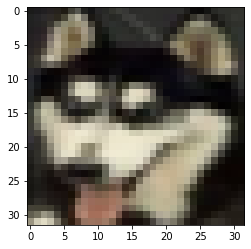

In [ ]:
#Let's plot the first image in the training set.
plt.imshow(X_train[23].transpose(1,2,0))

Next, we will pass our image through Objax's convolution routine. Carefully examine the following code and try to understand the dimension of the filter weights and the output. 

In [ ]:
# We append the first image with a batch size of 1 so it can be fed into a convolution layer
my_image = np.expand_dims(X_train[0], 0)

#Consider a very simple CNN filter with stride = 1 and no padding ('VALID').
Conv2d = objax.nn.Conv2D(nin = 3, nout = 2, k = 1, strides = 1, padding = 'VALID', use_bias = False)

filter_weights = Conv2d.w.value #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now

print("Filter weights:", filter_weights)
print("Conv output:", Conv2d(my_image))
print("Conv output shape:", np.shape(Conv2d(my_image)))

Filter weights: [[[[-0.04991655  0.15043241]
   [ 0.73415095  0.7302311 ]
   [ 0.42225453 -0.20575704]]]]
Conv output: [[[[0.131903   0.12756383 0.11289041 ... 0.8836789  0.8731076
    0.86833566]
   [0.17529473 0.15071984 0.15628213 ... 0.8996314  0.8999816
    0.89564246]
   [0.1796339  0.15359886 0.177978   ... 0.8970114  0.9008692
    0.89447534]
   ...
   [0.19092359 0.18224524 0.18224524 ... 0.23915055 0.24348971
    0.25650725]
   [0.16054939 0.15187104 0.15187104 ... 0.2651856  0.2608464
    0.2608464 ]
   [0.1431927  0.13885352 0.1431927  ... 0.325934   0.32159483
    0.30857733]]

  [[0.08789665 0.08524996 0.07811677 ... 0.434133   0.43353403
    0.43536472]
   [0.11436357 0.09826646 0.1045837  ... 0.46265456 0.46477225
    0.46212557]
   [0.11701027 0.10113011 0.11781716 ... 0.48742646 0.48734045
    0.47617286]
   ...
   [0.11645445 0.11116107 0.11116107 ... 0.16931616 0.17196286
    0.17990293]
   [0.09792761 0.09263422 0.09263422 ... 0.18519631 0.18254963
    0.18254963]


**In the cells below, you will create your own convolution routine that takes in the image and the initial weights used by Objax's own convolution routine (Conv2d.w.value) and show that your convolution routine returns the same value than Objax's.**

A simple implementation only requires 4 FOR loops. You may wish to draw inspiration from https://objax.readthedocs.io/en/latest/objax/nn.html?highlight=objax.nn.Conv2D#objax.nn.Conv2D

**Q2: Fill in the code for your custom convolution filter and show that it returnsthe same output as Objax’s own convolution routine.**

In [ ]:
#Solution to the above problem

def my_conv_net(my_image, initial_filter_weights):
  h = 32
  w = 32
  my_conv_output = np.zeros((1,2,32, 32))

  for c in range(2):
    for t in range(3):
      for h in range(32):
        for w in range(32):
          my_conv_output[0][c][h][w] += np.multiply(my_image[0][t][h][w],initial_filter_weights[0][0][t][c])

  return my_conv_output

my_conv_output = my_conv_net(my_image,filter_weights)

print("Filter weights:", filter_weights)
print("Conv output:", my_conv_net(my_image,filter_weights))
print("Conv output shape:", np.shape(my_conv_net(my_image,filter_weights)))

Filter weights: [[[[-0.04991655  0.15043241]
   [ 0.73415095  0.7302311 ]
   [ 0.42225453 -0.20575704]]]]
Conv output: [[[[0.131903   0.12756382 0.11289041 ... 0.8836789  0.87310763
    0.86833568]
   [0.17529472 0.15071983 0.15628213 ... 0.89963139 0.89998162
    0.89564245]
   [0.17963389 0.15359886 0.17797799 ... 0.89701142 0.9008692
    0.89447528]
   ...
   [0.19092358 0.18224524 0.18224524 ... 0.23915055 0.24348972
    0.25650724]
   [0.16054937 0.15187103 0.15187103 ... 0.26518558 0.26084641
    0.26084641]
   [0.14319268 0.13885351 0.14319268 ... 0.325934   0.32159482
    0.30857731]]

  [[0.08789665 0.08524996 0.07811677 ... 0.43413299 0.433534
    0.43536474]
   [0.11436357 0.09826646 0.10458369 ... 0.46265454 0.46477225
    0.46212556]
   [0.11701026 0.10113011 0.11781715 ... 0.48742648 0.48734048
    0.47617284]
   ...
   [0.11645445 0.11116107 0.11116107 ... 0.16931616 0.17196285
    0.17990292]
   [0.09792761 0.09263422 0.09263422 ... 0.18519631 0.18254962
    0.18254962]

The outputs of last convolution layer is typically rearranged so it can be fed into a linear layer. Check that calling .mean((2,3)) rearranges the output of your convolution routine by examining the shape of the output. (Not graded) Think about alternative ways of rearranging the output from the convolution layer. 

In [ ]:
#Check that .mean((2,3)) rearranges your image
my_conv_output.mean((2,3))

array([[0.30128768, 0.20166716]])

Take your rearranged output and feed it into a linear layer of appropriate size. Here is an example:

```
Linear_Layer = objax.nn.Linear(N, 1)
Y = Linear_Layer(X)
```
Next, extract the weights and bias of the linear layer using 
```
Linear_Layer.w.value
Linear_Layer.b.value
```
**Using these values, write one line of code that manually implements the linear layer. Show that it provides the same value as Objax's own linear layer.** 



**Q3:Fill in the code for your linear layer, and show that it returns the same outputas passing through Objax’s own linear layer.**

In [ ]:
Linear_Layer = objax.nn.Linear(2,1)
Y = Linear_Layer(my_conv_output.mean((2,3)))

w_value = Linear_Layer.w.value
b_value = Linear_Layer.b.value

print("w value is:",w_value, "b_value is",b_value)

output_value = np.dot(my_conv_output.mean((2,3)), Linear_Layer.w.value)

print("output_value:",output_value)
if Y == output_value:
  print("the two values are the same")

w value is: [[-0.97404206]
 [-0.31181675]] b_value is [0.]
output_value: [[-0.35635007]]
the two values are the same


**Q4: Difference between training and validation set:**

Training set is used to train the weights of the model, validation set is used to tune hyperparameters. 

When splitting the dataset, training set is usually the bigger portion of it.

You have now completed Part 1 of the assignment. Good job!


##**Part 2. Training and Tuning a CNN**

The following starter code trains the neural network in Part 1. However, the optimizer and batch sampling routine are left for you to implement. Complete the lines that says #PUT YOUR CODE HERE#

Afterwards, train the model, and observe the training/validation loss and accuracy plots. You should observe that the validation accuracy is low and stagnates after a few epochs.

**Q1:Complete the optimizer by using the definition of (stochastic) gradient descent**

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value = params.value - lr*grad                   
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

**Q2:Complete the batch sampling code in the train function by specifying a batch of examples.**

In [ ]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

**Q4:Traing model and visualize loss and accuracy**

Epoch 0001  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.86 Validation Accuracy 9.97
Epoch 0002  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 9.82 Validation Accuracy 10.00
Epoch 0003  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.18 Validation Accuracy 10.18
Epoch 0004  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.19 Validation Accuracy 10.88
Epoch 0005  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.70 Validation Accuracy 10.93
Epoch 0006  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 10.75 Validation Accuracy 11.30
Epoch 0007  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.32 Validation Accuracy 11.65
Epoch 0008  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.37 Validation Accuracy 11.98
Epoch 0009  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 11.81 Validation Accuracy 12.58
Epoch 0010  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 12.41 Validatio

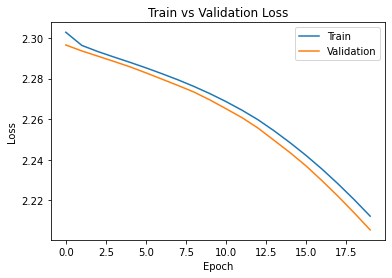

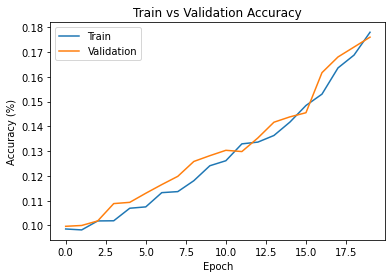

In [ ]:
train()

Follow the assignment handout for questions to be answered in this part of the assignment.

**Q4:Define the meaning of Hyperparameter**

We tune the hyperparameter by running a trained model with the validation set.
Hyperparameters contain information that indicates if we are potentially underfitting or overfitting our training model, a poorly trained model would be unhelpful and yield a greater loss and a less accuracy when running on the test set, thus it is important that we fine tune the hyperparameters so that our model is the best generalized possible.


**Q5:My set of hyperparameters**

H = {Learning Rate, Activation Function, Batch Size, Epochs} 

H_1 = {0.005, Sigmoid, 64, 30 }

H_2 = {0.0001, elu, 16, 35}

**Q6:Create two additional networks M1 and M2**

# ***M1 with H_1 = {0.005, Sigmoid, 64, 30 }***

In [ ]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.sigmoid])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.sigmoid])
    self.linear = objax.nn.Linear(32, number_of_classes) 

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
M1 = ConvNet()

#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = M1(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(M1(x)), M1.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, M1.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in M1.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value = params.value - lr*grad                   
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

def train(EPOCHS = 30, BATCH = 64, LEARNING_RATE = 5e-3):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.33 Validation Loss 2.30 Training Accuracy 10.11 Validation Accuracy 11.20
Epoch 0002  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.39 Validation Accuracy 11.83
Epoch 0003  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.42 Validation Accuracy 9.50
Epoch 0004  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 10.62 Validation Accuracy 13.42
Epoch 0005  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.80 Validation Accuracy 11.00
Epoch 0006  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.46 Validation Accuracy 13.22
Epoch 0007  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 12.04 Validation Accuracy 12.18
Epoch 0008  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.19 Validation Accuracy 12.82
Epoch 0009  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.96 Validation Accuracy 12.23
Epoch 0010  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.48 Validat

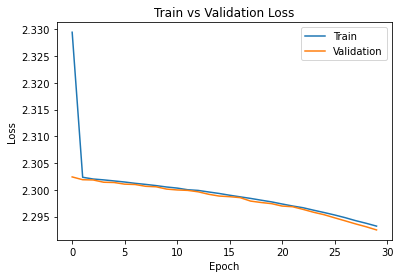

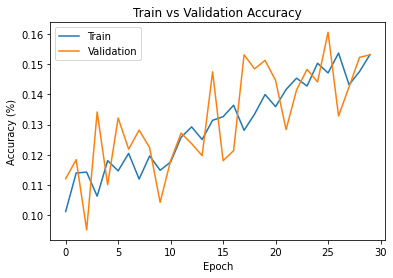

In [ ]:
train()

# ***M2 with H_2 = {0.0001, elu, 16, 35}***

In [ ]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.elu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.elu])
    self.linear = objax.nn.Linear(32, number_of_classes) 

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
M2 = ConvNet()

#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = M2(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(M2(x)), M2.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, M2.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in M2.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value = params.value - lr*grad                   
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

def train(EPOCHS = 35, BATCH = 16, LEARNING_RATE = 1e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.32 Validation Loss 2.31 Training Accuracy 11.03 Validation Accuracy 10.62
Epoch 0002  Training Loss 2.31 Validation Loss 2.30 Training Accuracy 10.04 Validation Accuracy 10.10
Epoch 0003  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.76 Validation Accuracy 9.88
Epoch 0004  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.63 Validation Accuracy 9.95
Epoch 0005  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 9.69 Validation Accuracy 10.08
Epoch 0006  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 9.97 Validation Accuracy 10.45
Epoch 0007  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.28 Validation Accuracy 10.87
Epoch 0008  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.74 Validation Accuracy 11.27
Epoch 0009  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 11.35 Validation Accuracy 11.80
Epoch 0010  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 11.91 Validation A

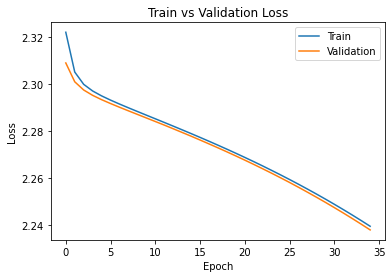

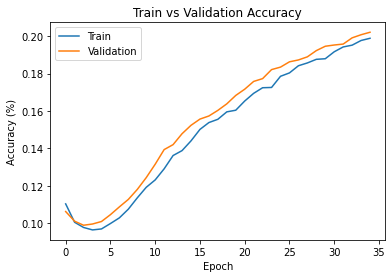

In [ ]:
train()

**Q7: Final Model**

Based on the loss and accuracy performance graphs, it is obvious that the M2 model is better than the other two models. The validation accuracy at the last epoch for each model is as following: 

Base Model (Epoch 22) -> 17.60

M1 (Epoch 30) -> 15.32

M2(Epoch 35) -> 20.22

For M1, we increased the number of epochs, changed the activation function to sigmoid, doubled the batch size and increase the learning rate. The change in hyperparameters that results in such a difference in loss and accuracy is probably the new activation function. ReLU has all negative values for all y > 0 wheras Sigmoid allows small negative values; For slightly positive values, Sigmoid exaggerats them more than ReLU, but for more positive values, Sigmoid function eventually levels off and has a smaller impact on the model, which doesn't happen in ReLU since it is linear for all positive values. 

For M2, we increased the number of epochs, changed the activation function to ELU, halved the batch size and decrease the learning rate. This time we chose an activation function that is more similar to ReLU. We train the model more thoroughly by decreasing the batch size and increasing the number of epochs, 
which explains why the M2 model brings out a higher accuracy to the other two models.


You have now completed Part 2 of the assignment. Good job!


##**Part 3. Trying Out a New Dataset**

See the handout for instructions.


**Q1:**Import and partition data

In [ ]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar100.load_data()
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

print(np.shape(X_train))
print(np.shape(Y_train))

(50000, 3, 32, 32)
(50000,)


In [ ]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar100.load_data()
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

169017344/169001437 [==============================] - 2s 0us/step


# **Q2:**Create a base model



In [ ]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 100):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes) 

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) # <--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
base_model = ConvNet()

#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = base_model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(base_model(x)), base_model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, base_model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in base_model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value = params.value - lr*grad                   
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

def train(EPOCHS = 35, BATCH = 16, LEARNING_RATE = 1e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 4.61 Validation Loss 4.61 Training Accuracy 0.76 Validation Accuracy 0.63
Epoch 0002  Training Loss 4.61 Validation Loss 4.61 Training Accuracy 0.75 Validation Accuracy 0.60
Epoch 0003  Training Loss 4.61 Validation Loss 4.61 Training Accuracy 0.71 Validation Accuracy 0.55
Epoch 0004  Training Loss 4.61 Validation Loss 4.61 Training Accuracy 0.68 Validation Accuracy 0.53
Epoch 0005  Training Loss 4.61 Validation Loss 4.61 Training Accuracy 0.66 Validation Accuracy 0.52
Epoch 0006  Training Loss 4.61 Validation Loss 4.61 Training Accuracy 0.62 Validation Accuracy 0.47
Epoch 0007  Training Loss 4.61 Validation Loss 4.61 Training Accuracy 0.60 Validation Accuracy 0.47
Epoch 0008  Training Loss 4.61 Validation Loss 4.61 Training Accuracy 0.58 Validation Accuracy 0.45
Epoch 0009  Training Loss 4.61 Validation Loss 4.61 Training Accuracy 0.55 Validation Accuracy 0.42
Epoch 0010  Training Loss 4.61 Validation Loss 4.61 Training Accuracy 0.54 Validation Accuracy 0.40


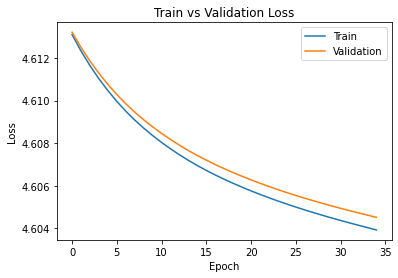

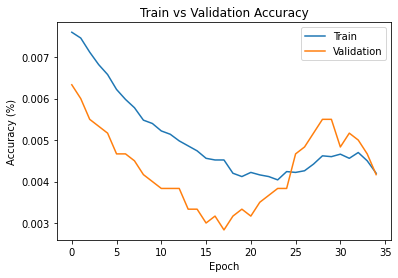

In [ ]:
train()

# **Q3:** Pick hyperparameter

We pick our hyperparameter to be: 

H = {Learning Rate,  Epochs,number of outputs of conv layer 1} 

H = {8*e-3, 50, 32}

In [ ]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 100):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 32, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes) 

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
M1 = ConvNet()

#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = M1(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(M1(x)), M1.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, M1.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in M1.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value = params.value - lr*grad                   
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

def train(EPOCHS = 50, BATCH = 16, LEARNING_RATE = 8e-3):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.34 Validation Loss 2.13 Training Accuracy 22.06 Validation Accuracy 19.43
Epoch 0002  Training Loss 2.13 Validation Loss 2.11 Training Accuracy 26.10 Validation Accuracy 21.82
Epoch 0003  Training Loss 2.09 Validation Loss 2.07 Training Accuracy 27.86 Validation Accuracy 22.25
Epoch 0004  Training Loss 2.05 Validation Loss 2.02 Training Accuracy 29.25 Validation Accuracy 25.18
Epoch 0005  Training Loss 2.00 Validation Loss 1.99 Training Accuracy 30.29 Validation Accuracy 23.72
Epoch 0006  Training Loss 1.96 Validation Loss 1.93 Training Accuracy 31.89 Validation Accuracy 27.07
Epoch 0007  Training Loss 1.93 Validation Loss 1.90 Training Accuracy 32.96 Validation Accuracy 28.48
Epoch 0008  Training Loss 1.90 Validation Loss 1.88 Training Accuracy 33.94 Validation Accuracy 27.18
Epoch 0009  Training Loss 1.87 Validation Loss 1.85 Training Accuracy 34.81 Validation Accuracy 32.43
Epoch 0010  Training Loss 1.85 Validation Loss 1.84 Training Accuracy 35.98 Valida

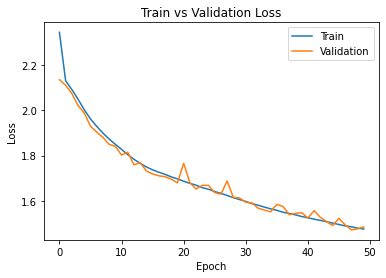

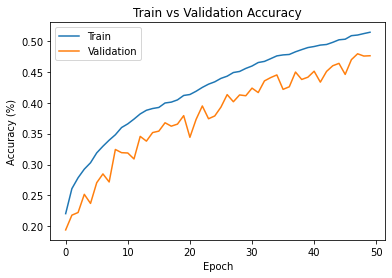

In [ ]:
train()

**Discussions and Results:**


H = {Learning Rate, Epochs,number of outputs of conv layer 1} 

H = {8*e-3, 50, 32}
Major changes in hyperparameter are the number of outputs of convolution layer 1 and the number of epochs. We chose to slightly decreasing learning rate so that the training process doesn't take too long to complete.

We increased the width of the model by increasing the number of outputs of convolution layer 1, this adds to the width and complexity of the current model, and thus improve the previous underfitted model. We also increased the number of training epochs so that the model can be trained on the images more thoroughly. The new validation accuracy is now 47.58, which improved a lot compared to the base model accuracy 0.42.

**Q4:**Select final model and report accuracy

In [ ]:
predict = objax.Jit(lambda x: objax.functional.softmax(M1(x)), M1.vars()) 

test_prediction = predict(X_test).argmax(1)
test_acc = (np.array(test_prediction).flatten() == Y_test).sum()

test_acc = test_acc/X_test.shape[0]
print(test_acc)

0.5088333333333334


##**Problem 4. Open-Ended Exploration**

See the handout for instructions.

**Question : Additional hyperparameter tuning**

Come up with one or several hyperparametersthat you have not tried in the previous parts (e.g., explore arguments of the methodobjax.nn.Cov2d),  tune  them  on  the  validation  set  until  you  see  (at-least)  5%-10%increase in the validation accuracy as compared to a base model.  Discuss whether itperforms well on the test set as compared to your base model.

**Hyperparameter we are tuning for this part:** *number of convolution layers*

we will add another hidden layer to our neural network, and visualize the loss and accuracy on a plot.

In [ ]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 100):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 32, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 2), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes) 

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = objax.functional.max_pool_2d(self.conv_2(x),2,2)
    x = self.conv_3(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
M1 = ConvNet()

#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = M1(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(M1(x)), M1.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, M1.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in M1.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value = params.value - lr*grad                   
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

def train(EPOCHS = 35, BATCH = 16, LEARNING_RATE = 8e-3):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

**Results:**
The final validation accuracy reaches 50.52, which was 0.42 for the base model. 
The poor performance of the base model can be perceived as a result of highly underfitted model. We directed copied the same model used for CIFAR10 which only has 10 classes to be our base model for the current dataset, which contains 100 classes, esstentially at least 10 times more information. The old hyperparameters that worked well for CIFAR10 have proven to be insufficient for CIFAR100, we have to increase the complexity of the model for it to generalize better. Adding another hidden layer of neural network adds to the depth of our current DNN and helps improve the performance of the model this way.

 At the same time, decreasing batch size and increasing number of epochs also increase validation accuracy because the model essentially goes through the images in a more dense fashion and learns the data better.

Epoch 0001  Training Loss 2.37 Validation Loss 2.14 Training Accuracy 21.85 Validation Accuracy 21.60
Epoch 0002  Training Loss 2.12 Validation Loss 2.12 Training Accuracy 25.97 Validation Accuracy 18.98
Epoch 0003  Training Loss 2.07 Validation Loss 2.08 Training Accuracy 27.45 Validation Accuracy 21.15
Epoch 0004  Training Loss 2.01 Validation Loss 1.96 Training Accuracy 30.29 Validation Accuracy 27.68
Epoch 0005  Training Loss 1.94 Validation Loss 1.89 Training Accuracy 32.84 Validation Accuracy 28.70
Epoch 0006  Training Loss 1.88 Validation Loss 1.86 Training Accuracy 35.12 Validation Accuracy 28.47
Epoch 0007  Training Loss 1.84 Validation Loss 1.79 Training Accuracy 36.79 Validation Accuracy 32.10
Epoch 0008  Training Loss 1.80 Validation Loss 1.85 Training Accuracy 38.02 Validation Accuracy 29.85
Epoch 0009  Training Loss 1.77 Validation Loss 1.88 Training Accuracy 39.39 Validation Accuracy 27.82
Epoch 0010  Training Loss 1.75 Validation Loss 1.73 Training Accuracy 40.22 Valida

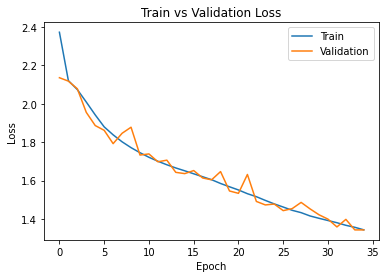

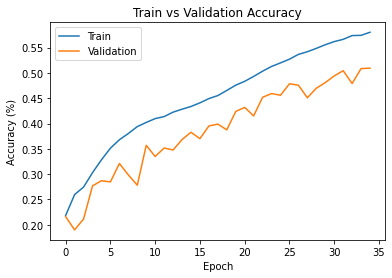

In [ ]:
train()